# Gradient Descent

In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

We can use our animation skills to illustrate gradient descent. This is that celebrated machine learning algorithm that finds the minimum of a cost function by using the (negative) gradient of that function iteratively to improve guesses as to the optimal parameter values.

## Setting up a Regression Problem

In [2]:
np.random.seed(42)

x = np.random.rand(100, 1)
y = [2*x_i + 10 + 2*np.random.rand() for x_i in x];

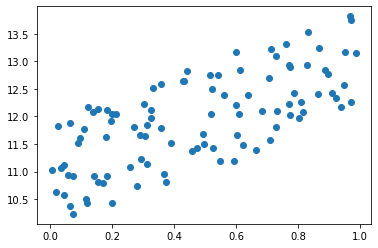

In [3]:
plt.scatter(x, y);

## Calculate Optimal Parameters

In [4]:
lr = LinearRegression().fit(x, y)
print(lr.intercept_)
print(lr.coef_[0])

[11.02719531]
[1.93293671]


## Illustrate Relative Positions of Lines and Positions in Parameter Space

First we'll build a function that will show, for *two* inputs each of slope and intercept, where the associated line is relative to our data points and also where we are on the (3-d) cost curve in parameter space.

In [5]:
def sse(m, x, b, y):
    """
    This function returns the sum of squared errors for
    a target y and a linear estimate mx + b.
    """
    return len(x) * mean_squared_error(y, m*x + b)

The next function will make use of [`matplotlib` colormaps](https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html) to plot the 3-d cost curve.

In [6]:
def plot_line_and_point_in_beta_space(slope1, const1, slope2, const2, x, y,
                                     data_color='k', line_color='m',
                                     cmap='binary', spot_color='r'):
    """
    This function will plot the lines through a set of data points
    and the positions in "beta space" for *two* inputs each of
    slope and y-intercept for a simple linear regression problem.
    """
    import numpy as np
    from matplotlib import pyplot as plt
    from sklearn.linear_model import LinearRegression
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
    ax0.scatter(x, y, c=data_color)
    ax0.plot(x, slope1*x + const1, c=line_color)
    
    ax1.scatter(x, y, c=data_color)
    ax1.plot(x, slope2*x + const2, c=line_color)
    plt.show()
    
    model = LinearRegression().fit(x, y)
    true_slope = model.coef_[0]
    true_const = model.intercept_
    
    # This section of code just insures that the plot will
    # include the true slope and intercept values.
    if slope1 < true_slope:
        ms1 = np.linspace(slope1, 2*true_slope - slope1, 100)
    else:
        ms1 = np.linspace(2*true_slope - slope1, slope1, 100)
    
    if const1 < true_const:
        bs1 = np.linspace(const1, 2*true_const - const1, 100)
    else:
        bs1 = np.linspace(2*true_const - const1, const1, 100)
        
    if slope2 < true_slope:
        ms2 = np.linspace(slope2, 2*true_slope - slope2, 100)
    else:
        ms2 = np.linspace(2*true_slope - slope2, slope2, 100)
    
    if const2 < true_const:
        bs2 = np.linspace(const2, 2*true_const - const2, 100)
    else:
        bs2 = np.linspace(2*true_const - const2, const2, 100)

    X_grid1, Y_grid1 = np.meshgrid(ms1, bs1)

    Z1 = np.array([[sse(m, x, b, y) for m in ms1] for b in bs1])
    
    X_grid2, Y_grid2 = np.meshgrid(ms2, bs2)
    
    Z2 = np.array([[sse(m, x, b, y) for m in ms2] for b in bs2])

    fig = plt.figure(figsize=(10, 8))
    ax2 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2.contour3D(X_grid1, Y_grid1, Z1, 200, cmap=cmap)
    ax2.set_xlabel('slope')
    ax2.set_ylabel('y-intercept')
    ax2.scatter(slope1, const1, sse(slope1, x, const1, y),
               c=spot_color, marker='o', s=200)
    
    ax3 = fig.add_subplot(1, 2, 2, projection='3d')
    ax3.contour3D(X_grid2, Y_grid2, Z2, 200, cmap=cmap)
    ax3.set_xlabel('slope')
    ax3.set_ylabel('y-intercept')
    ax3.scatter(slope2, const2, sse(slope2, x, const2, y),
               c=spot_color, marker='o', s=200)

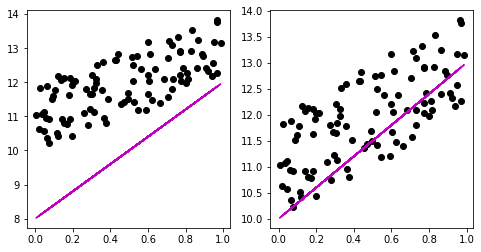

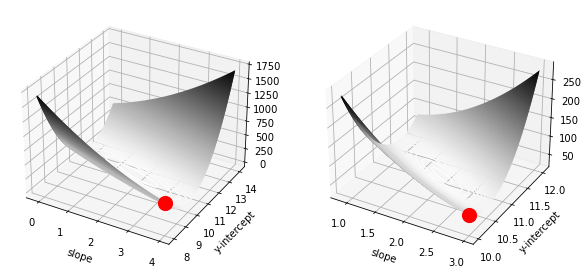

In [7]:
plot_line_and_point_in_beta_space(4, 8, 3, 10, x, y)

## Gradient Descent Animated

But if we want to show how guesses *improve* using gradient descent, then we'll need to code up that algorithm. First we'll code up the partial derivatives of the loss function.

In [8]:
def partial_deriv(a, b, x_i, y_i, respect_to):
    """
    Get the partial derivative for cost function with respect to slope (a) 
    or intercept (b).
    """
    if respect_to == 'b': # intercept
        return (y_i - (a * x_i + b))
    elif respect_to == 'a': # slope
        return (x_i * (y_i - (a * x_i + b)))
    else:
        print('Choose either respect_to: a or b ')
        return 0

Now we'll express one iteration of the algorithm: Take an initial guess and then improve them by going in the opposite direction of the gradient at that point.

In [9]:
def step_gradient(a, b, x, y, learning_rate):
    """
    This function returns a new slope-intercept pair, calculated
    using gradient descent, for input data and an initial pair of
    guesses.
    """
    db = 0
    da = 0 
    # For each data point, update the derivative for the slope & intercept
    N = len(x)
    for i in range(N):
        
        # Partial derivatives of loss/cost function with respect to b & a
        # Here's where we're taking our averages. Notice that we're leaving
        # off the factors of 2.
        db +=  -(1/N) * partial_deriv(a, b, x[i], y[i], respect_to='b')
        da +=  -(1/N) * partial_deriv(a, b, x[i], y[i], respect_to='a')
        
    # Adjust the slope & intercept by the gradient
    new_b = b - (learning_rate * db)
    new_a = a - (learning_rate * da)
    
    return new_a, new_b

Now we're ready!

In [10]:
def grad_desc_illus(slope_init, const_init, x, y, n_iter=100, alpha=1,
                   line_color='c', data_color='k'):
    """
    This function illustrates gradient descent by repeatedly applying
    the step_gradient() function and visualizing the results.
    """
    new_slope, new_const = slope_init, const_init
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c=data_color)
    plt.plot(x, slope_init*x + const_init)
    for _ in range(n_iter):
        clear_output(wait=True)
        guess = {
            'slope': new_slope,
            'intercept': new_const
        }

        beta_1, beta_0 = step_gradient(guess['slope'],
                                       guess['intercept'],
                                       x, y, learning_rate=alpha)
        new_slope = beta_1
        new_const = beta_0
        plt.figure(figsize=(10, 6))
        plt.scatter(x, y, c=data_color)
        plt.plot(x, new_slope*x + new_const, c=line_color)
        plt.show()
    
    return new_slope[0], new_const[0]

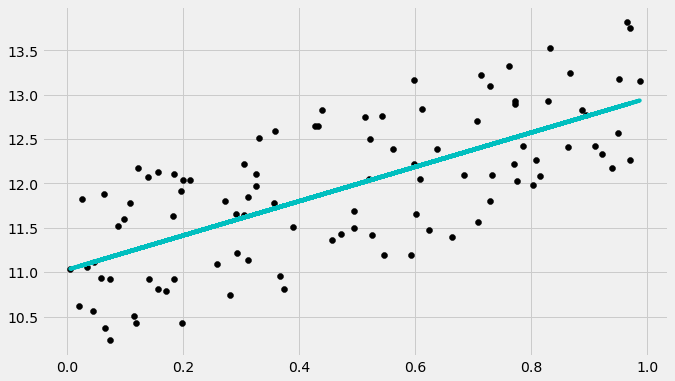

(1.9342788190809492, 11.026516215829108)

In [11]:
grad_desc_illus(3, 8, x, y, alpha=1)

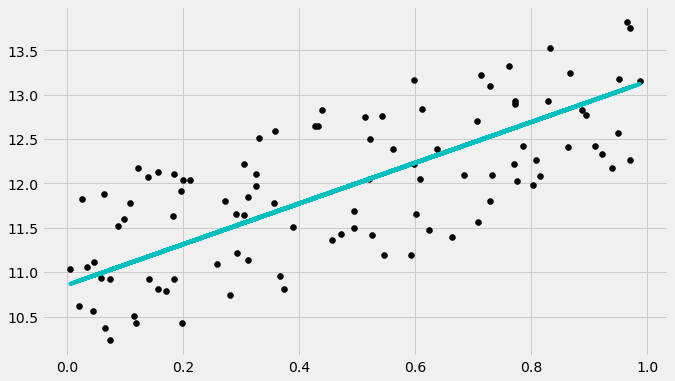

In [ ]:
grad_desc_illus(3, 12, x, y, alpha=0.2)

In [ ]:
grad_desc_illus(10, -5, x, y, line_color='m', data_color='brown')

## Evolution in Slope-Intercept Space

Let's now get this animation working for our points in beta space.

In [ ]:
def grad_desc_illus_betas(slope_init, const_init, x, y, n_iter=100, alpha=1,
                          color='k', figsize=(8, 8), cmap='binary'):
    """
    This function illustrates gradient descent by repeatedly applying
    the step_gradient() function and visualizing the results in
    parameter space.
    """
    import numpy as np
    from matplotlib import pyplot as plt
    from sklearn.linear_model import LinearRegression
    
    model = LinearRegression().fit(x, y)
    true_slope = model.coef_[0]
    true_const = model.intercept_
    
    if slope_init < true_slope:
        ms = np.linspace(slope_init, 2*true_slope - slope_init, 100)
    else:
        ms = np.linspace(2*true_slope - slope_init, slope_init, 100)
    
    if const_init < true_const:
        bs = np.linspace(const_init, 2*true_const - const_init, 100)
    else:
        bs = np.linspace(2*true_const - const_init, const_init, 100)

    X_grid, Y_grid = np.meshgrid(ms, bs)

    Z = np.array([[sse(m, x, b, y) for m in ms] for b in bs])
    new_slope, new_const = slope_init, const_init
    plt.style.use('fivethirtyeight')
    
    plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.contour3D(X_grid, Y_grid, Z, 200, cmap=cmap)
    ax.set_xlabel('slope')
    ax.set_ylabel('y-intercept')
    ax.set_zlabel('sum of squared errors')
    ax.scatter(new_slope, new_const, sse(new_slope, x, new_const, y),
                   c=color, marker='o', s=200)
    plt.title('Error as a function of slope and y-intercept');

    for i in range(n_iter):
        clear_output(wait=True)
        guess = {
            'slope': new_slope,
            'intercept': new_const
        }

        beta_1, beta_0 = step_gradient(guess['slope'],
                                       guess['intercept'],
                                       x, y, learning_rate=alpha)
        new_slope = beta_1
        new_const = beta_0
        plt.figure(figsize=figsize)
        ax = plt.axes(projection='3d')
        ax.contour3D(X_grid, Y_grid, Z, 200, cmap=cmap)
        ax.set_xlabel('slope')
        ax.set_ylabel('y-intercept')
        ax.scatter(beta_1, beta_0, sse(beta_1, x, beta_0, y),
                   c=color, marker='o', s=200)
        plt.show()

In [ ]:
grad_desc_illus_betas(5, 5, x, y, n_iter=10)

In [ ]:
grad_desc_illus_betas(10, 2, x, y, n_iter=50)

In [ ]:
grad_desc_illus_betas(-8, 15, x, y, n_iter=25)

In [ ]:
grad_desc_illus_betas(-12, -20, x, y, color='r', alpha=0.01)